# Simple Forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as mape

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
plt.rcParams["figure.figsize"] = (16, 10)

<IPython.core.display.Javascript object>

----------------------------------------

## Read Data

In [4]:
trips = pd.read_csv("../data/trips/daily_trips.csv")
trips.date = pd.to_datetime(trips.date)
trips.rename(columns={"date": "ds", "daily_trips": "y"}, inplace=True)

weather = pd.read_csv("../data/weather/daily_weather.csv")
weather.date = pd.to_datetime(weather.date)
weather.rename(
    columns={
        "date": "ds",
        "Normal_Max_Temp_C": "tmax",
        "Normal_Min_Temp_C": "tmin",
        "Normal_Precipitation_CM": "precip",
    },
    inplace=True,
)

trips = pd.merge(trips, weather, on="ds", how="left")

holidays = pd.read_csv("../data/holidays/holidays.csv")
holidays.ds = pd.to_datetime(holidays.ds)

<IPython.core.display.Javascript object>

## Simple Forecast

Use Prophet to create a simple forecast.  Don't do any tuning, CV, etc, just create a forecast on one training dataset and test the performance on a test dataset

### Train / Test Split

In [5]:
train = trips[trips.ds <= "2016-12-31"]
test = trips[trips.ds >= "2017-01-01"]

<IPython.core.display.Javascript object>

### Fit and Predict

In [6]:
m = Prophet(seasonality_mode="multiplicative")
m.fit(train)
# future = m.make_future_dataframe(periods=365 * 2)

20:44:03 - cmdstanpy - INFO - Chain [1] start processing
20:44:03 - cmdstanpy - INFO - Chain [1] done processing


<IPython.core.display.Javascript object>

In [7]:
forecast = m.predict(trips)

<IPython.core.display.Javascript object>

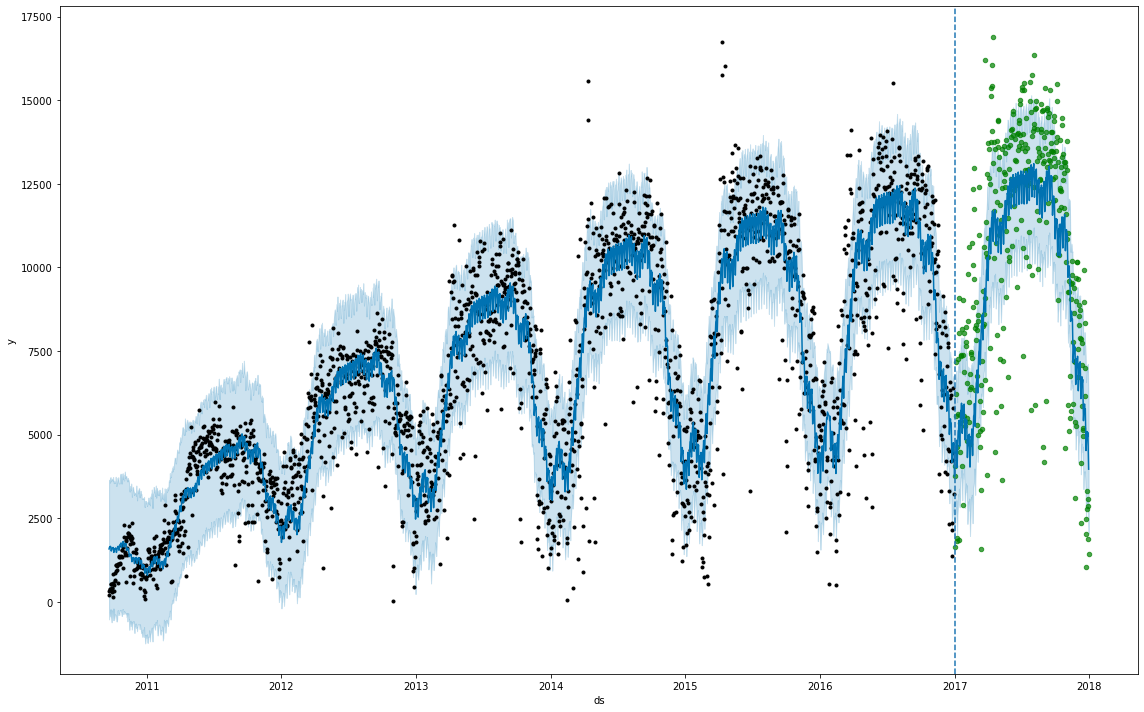

<IPython.core.display.Javascript object>

In [8]:
fig, ax = plt.subplots(1, 1)
m.plot(forecast, ax=ax)
test.plot.scatter(x="ds", y="y", ax=ax, marker="o", color="green", alpha=0.7)
ax.axvline(dt.datetime(2017, 1, 1), linestyle="dashed")
plt.show()

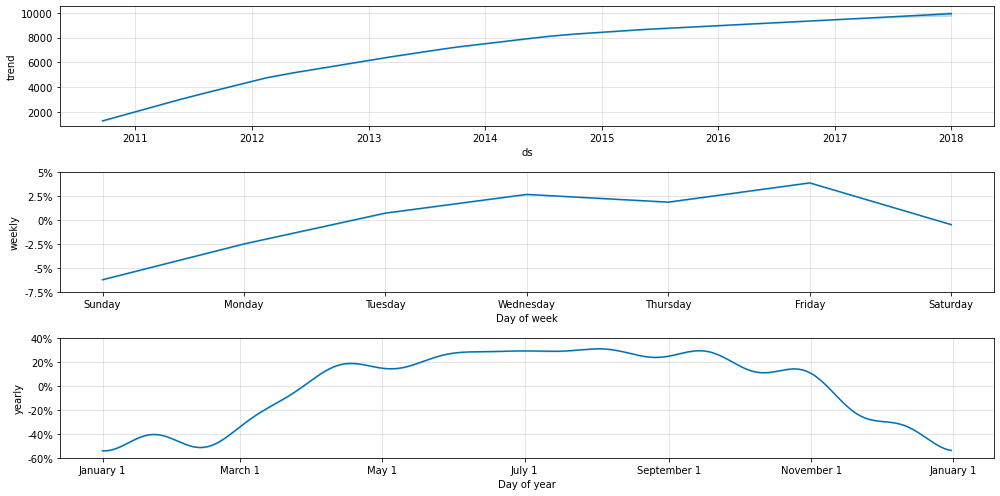

<IPython.core.display.Javascript object>

In [9]:
component_plot = m.plot_components(forecast, figsize=(14, 7))

### Add Holidays

In [10]:
# Add Holidays
m2 = Prophet(holidays=holidays, seasonality_mode="multiplicative")
m2.fit(train)
forecast2 = m2.predict(trips)

20:44:05 - cmdstanpy - INFO - Chain [1] start processing
20:44:05 - cmdstanpy - INFO - Chain [1] done processing


<IPython.core.display.Javascript object>

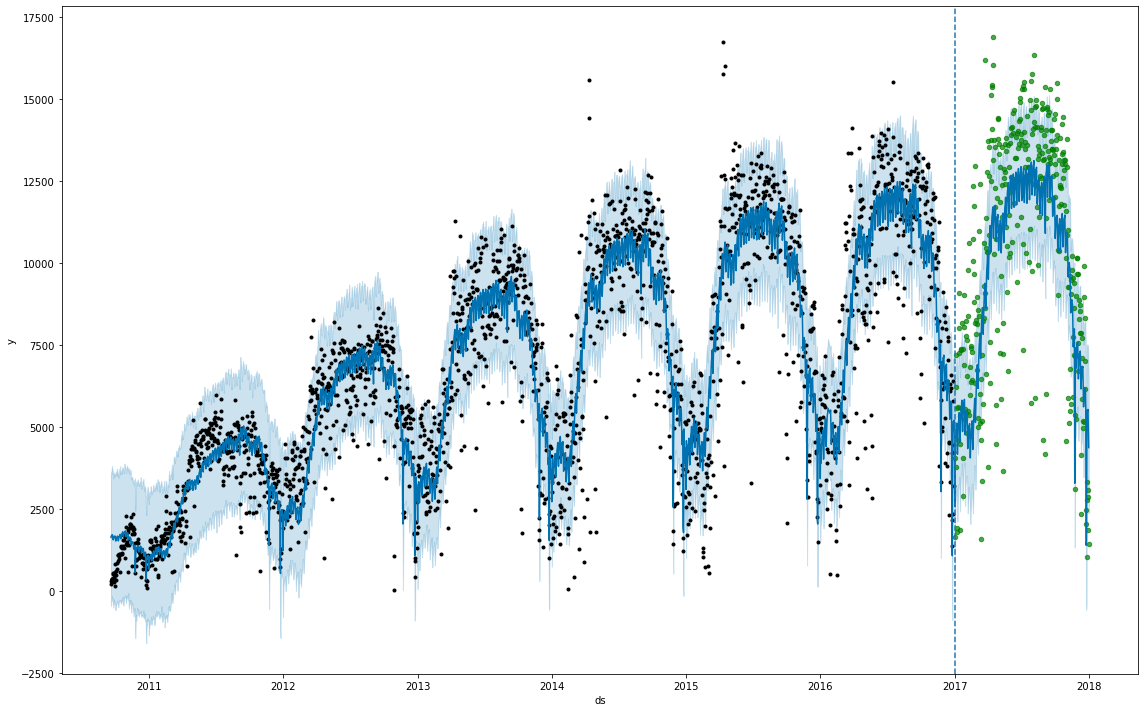

<IPython.core.display.Javascript object>

In [11]:
fig, ax = plt.subplots(1, 1)
plt2 = m2.plot(forecast2, ax=ax)
points = test.plot.scatter(x="ds", y="y", ax=ax, marker="o", color="green", alpha=0.7)
sep_line = ax.axvline(dt.datetime(2017, 1, 1), linestyle="dashed")
plt.show()

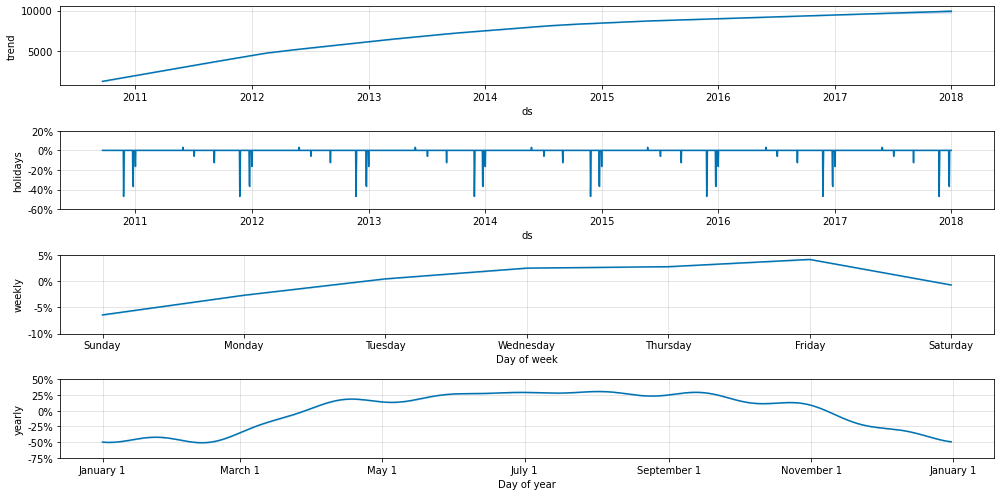

<IPython.core.display.Javascript object>

In [12]:
m2_components = m2.plot_components(forecast2, figsize=(14, 7))

### Add Weather Data

In [13]:
m3 = Prophet(holidays=holidays, seasonality_mode="multiplicative")
m3.add_regressor("tmax")
m3.add_regressor("precip")
# m3.add_regressor('tmin') # don't add tmin as it is too correlated with tmax
m3.fit(trips)
forecast3 = m3.predict(trips)

20:44:07 - cmdstanpy - INFO - Chain [1] start processing
20:44:07 - cmdstanpy - INFO - Chain [1] done processing


<IPython.core.display.Javascript object>

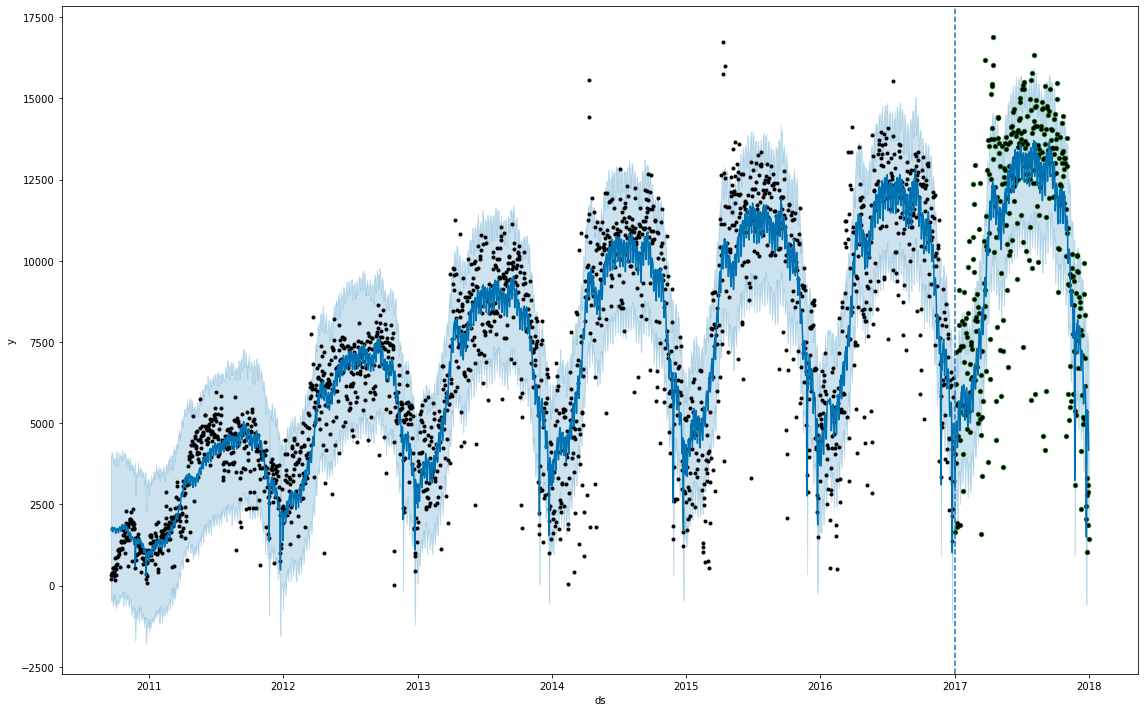

<IPython.core.display.Javascript object>

In [14]:
fig, ax = plt.subplots(1, 1)
plt3 = m3.plot(forecast3, ax=ax)
points = test.plot.scatter(x="ds", y="y", ax=ax, marker="o", color="green", alpha=0.7)
sep_line = ax.axvline(dt.datetime(2017, 1, 1), linestyle="dashed")
plt.show()

In [15]:
residuals = forecast3.merge(trips[["ds", "y"]], how="left", on="ds")[
    ["ds", "y", "yhat"]
]
residuals

,ds,y,yhat
0,2010-09-20,212,1698.669320
1,2010-09-21,324,1759.877146
2,2010-09-22,377,1781.729124
3,2010-09-23,373,1766.165965
4,2010-09-24,362,1798.319344
...,...,...,...
2651,2017-12-27,3321,5410.031309
2652,2017-12-28,2866,5328.242159
2653,2017-12-29,3088,5356.915207
2654,2017-12-30,1876,4840.563561


<IPython.core.display.Javascript object>

In [16]:
residuals["resid"] = residuals.y - residuals.yhat
residuals = residuals[["ds", "resid"]]
residuals.set_index("ds", inplace=True)

<IPython.core.display.Javascript object>

/home/allen/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


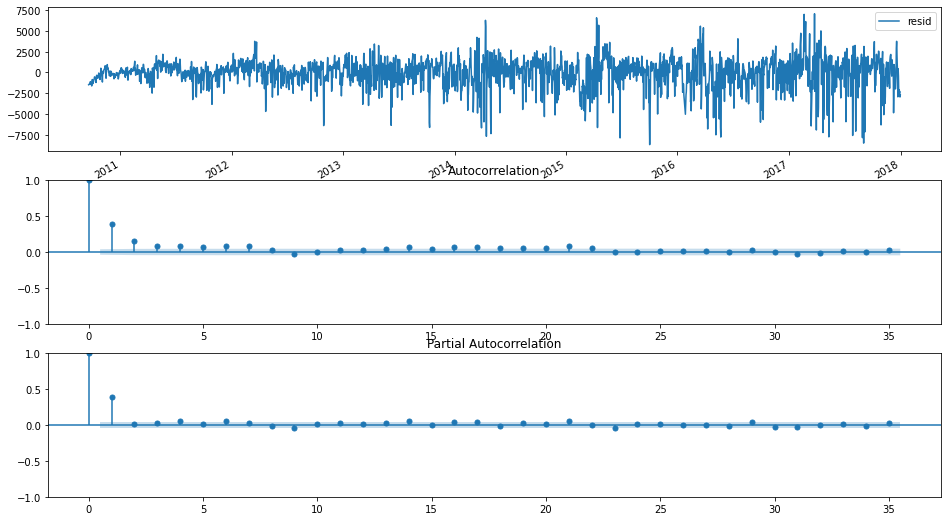

<IPython.core.display.Javascript object>

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
residuals.plot(legend="residuals", ax=ax1)
plot_acf(residuals, ax=ax2)
plot_pacf(residuals, ax=ax3)
plt.show()

## Mape on Test Set

In [18]:
preds = m3.predict(test)
preds = preds[["ds", "yhat"]]
testset = test[["ds", "y"]]
testset = pd.merge(testset, preds, how="left", on="ds")

<IPython.core.display.Javascript object>

In [19]:
mape(y_true=testset.y, y_pred=testset.yhat)

0.25047194833205694

<IPython.core.display.Javascript object>